# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [ ]:
!pip install numpy==1.26.4 -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import os
import re
import statistics
from PIL import Image
import torch.nn as nn

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

import torch
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.layers import Dense, Dropout

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from sklearn.model_selection import GroupShuffleSplit
from keras.applications import ResNet50
import torchvision.models as models
from keras.preprocessing import image
from tensorflow.keras.models import Model
from functools import lru_cache
from torchvision import transforms
from keras.applications.resnet50 import preprocess_input
from sklearn.dummy import DummyRegressor
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

from transformers import AutoTokenizer, AutoModel
from keras.models import Sequential
from keras.optimizers import Adam


import warnings
warnings.simplefilter(action='ignore')

In [ ]:
RANDOM_STATE=12345

In [ ]:
!wget https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip

In [ ]:
 !unzip dsplus_integrated_project_4.zip

Archive:  dsplus_integrated_project_4.zip
replace to_upload/test_images.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls to_upload

CrowdAnnotations.tsv   test_images	test_queries.csv   train_images
ExpertAnnotations.tsv  test_images.csv	train_dataset.csv


In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("omw-1.4")
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

DATA_PATH = '/content/to_upload/'

In [ ]:
# загружаем данные и сохраняем в переменные
train_dataset = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))

In [ ]:
file_path = '/content/to_upload/train_dataset.csv'
print(file_path)
if os.path.exists(file_path):
    train_df = pd.read_csv(file_path)
    print("Data loaded successfully!")
else:
    print("File not found:", file_path)

/content/to_upload/train_dataset.csv
Data loaded successfully!


In [ ]:
PATH = '/content/to_upload/'

In [ ]:
train_data = pd.read_csv(os.path.join(PATH, 'train_dataset.csv'))
train_data.name = 'train_data'
data_crowd = pd.read_csv(os.path.join(PATH, 'CrowdAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'conf_rate', 'confirm', 'not_confirm'])
data_crowd.name = 'data_crowd'
data_expert = pd.read_csv(os.path.join(PATH, 'ExpertAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'exp_1', 'exp_2', 'exp_3'])
data_expert.name = 'data_expert'
test_query = pd.read_csv(os.path.join(PATH, 'test_queries.csv'), index_col=[0], sep='|')
test_query.name = 'test_query'
test_images = pd.read_csv(os.path.join(PATH, 'test_images.csv'))
test_images.name = 'test_images'

In [ ]:
def display_table_info(name, data):
    print(name)
    display(data.head(10))
    data.info()
    print('')
    print('')
    print('')

display_table_info('train_data', train_data)
display_table_info('data_crowd', data_crowd)
display_table_info('data_expert', data_expert)
display_table_info('test_query', test_query)
display_table_info('test_images', test_images)

train_data


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB



data_crowd


,image,query_id,conf_rate,confirm,not_confirm
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   conf_rate    47830 non-null  float64
 3   confirm      47830 non-null  int64  
 4   not_confirm  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB



data_expert


,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB



test_query


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
5,1232148178_4f45cc3284.jpg#0,A baby girl playing at a park .,1232148178_4f45cc3284.jpg
6,1232148178_4f45cc3284.jpg#1,A closeup of a child on a playground with adul...,1232148178_4f45cc3284.jpg
7,1232148178_4f45cc3284.jpg#2,A young boy poses for a picture in front of a ...,1232148178_4f45cc3284.jpg
8,1232148178_4f45cc3284.jpg#3,A young girl is smiling in front of the camera...,1232148178_4f45cc3284.jpg
9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB



test_images


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
5,424307754_1e2f44d265.jpg
6,3044359043_627488ddf0.jpg
7,3396275223_ee080df8b5.jpg
8,2977379863_2e8d7a104e.jpg
9,634891010_9fa189effb.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes





Выведем изображения

Запрос: Chinese market street in the winter time .


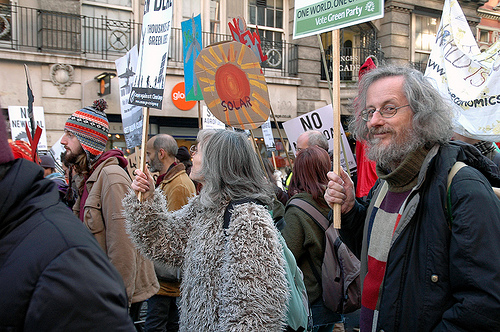



Запрос: A topless woman is covered in mud .


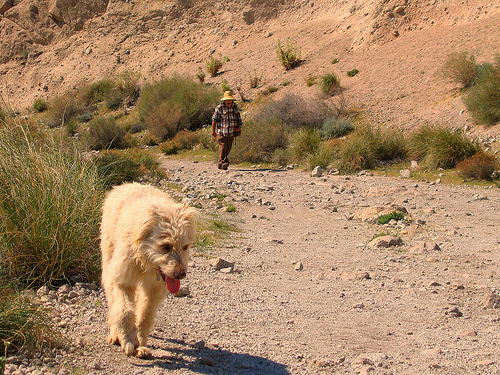



Запрос: A smiling boy in an orange shirt with a safari hat sits at the playground , while a boy in a blue shirt looks on .


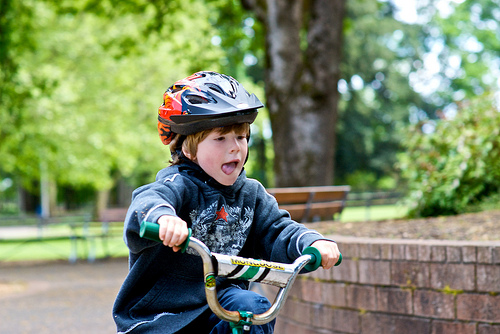



Запрос: A tan dog jumps into water .


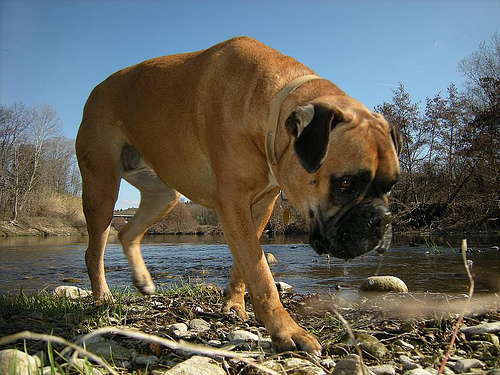



Запрос: A person swimming in water nearby rocks and a small waterfall .


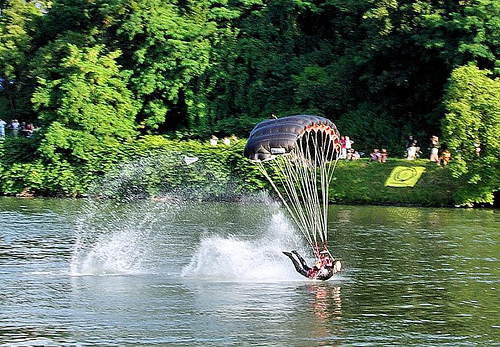

In [ ]:
for row in train_data.sample(5).values.tolist():
  print(f"Запрос:", row[2])
  with Image.open(os.path.join(PATH, 'train_images', row[0])) as im:
    display(im)
  print("\n")

Данные корректны пропусков нет. Изучим подробнее экспертные мнения для агрегации оценок.

In [ ]:
for i in range(3):
    exp_ = i + 1
    fig = px.histogram(data_expert, x=f'exp_{exp_}', nbins=100,
                       labels={'value': 'Оценка эксперта', 'count': 'Кол-во оценок'},
                       title=f"Распределение оценок эксперта №{exp_}")
    fig.update_layout(width=800, height=400)
    fig.show()


Чаще всего эксперты ставят 1. Агрегируем их оценки. Возьмем медиану от 3 оценок

In [ ]:
data_expert.loc[:, 'exp_total'] = data_expert[['exp_1', 'exp_2', 'exp_3']].median(axis=1)

In [ ]:
scaler = MinMaxScaler()

data_expert['exp_norm'] = scaler.fit_transform(data_expert[['exp_total']])

In [ ]:
fig = px.histogram(data_expert, x='exp_norm',
                   labels={'value': 'Оценка', 'count': 'Частота'},
                   title='Распределение нормализованных данных')
fig.update_layout(width=800, height=400)
fig.show()

In [ ]:
data_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      5822 non-null   object 
 1   query_id   5822 non-null   object 
 2   exp_1      5822 non-null   int64  
 3   exp_2      5822 non-null   int64  
 4   exp_3      5822 non-null   int64  
 5   exp_total  5822 non-null   float64
 6   exp_norm   5822 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 318.5+ KB


In [ ]:
data_expert.head(10)

,image,query_id,exp_1,exp_2,exp_3,exp_total,exp_norm
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0,0.000000
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1,1.0,0.000000
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1,1.0,0.000000
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2,1.0,0.000000
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1,1.0,0.000000
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2,2.0,0.333333


In [ ]:
data_expert['exp_norm'].describe()

,exp_norm
count,5822.000000
mean,0.208119
std,0.285407
min,0.000000
25%,0.000000
50%,0.000000
75%,0.333333
max,1.000000


In [ ]:
train_data.shape

(5822, 3)

In [ ]:
data_expert.shape

(5822, 7)

In [ ]:
train_data = pd.merge(train_data, data_expert[['image', 'query_id', 'exp_norm']],
                       how='left', on=['image', 'query_id'])

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для начала лемматизируем описания, а после этого уже напишем функцию для удаления изображений в описание которых входят слова связанные с детьми

In [ ]:
train_data.shape

(5822, 4)

In [ ]:
lemmatizer = WordNetLemmatizer()

def pos_tag(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
%%time
train_data["lemm_query"] = train_data["query_text"].apply(
    lambda x: " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)]
    )
)

CPU times: user 9.31 s, sys: 671 ms, total: 9.99 s
Wall time: 10.1 s


In [ ]:
%%time
test_query["lemm_query"] = test_query["query_text"].apply(
    lambda x: " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)]
    )
)

CPU times: user 719 ms, sys: 43.8 ms, total: 763 ms
Wall time: 764 ms


In [ ]:
test_query["lemm_query"] = test_query["lemm_query"].apply(
    lambda x: (" ".join(re.sub(r"[^a-zA-Z ]", " ", x).split()).lower())
)

Напишем функцию, в которой будем искать слова из стоп-листа BLOCK_WORDS в заданном тексте text. Возвращаем True, если нашлось хотя бы одно слово

In [ ]:
BLOCK_WORDS = ['child', 'boy', 'girl', 'baby', 'teen', 'teenager', 'kid', 'infant', \
               'youngster', 'kids', 'children', 'boys', 'girls', 'babies', 'teens', \
               'teenagers', 'youth', 'toddler', 'adolescent', 'juvenile', 'offspring', \
               'minors', 'junior', 'tots', 'youthful', 'newborn', 'offspring', 'little one', \
               'munchkin', 'toddlers']

In [ ]:
def child_in_text(text: str) -> bool:

    res = False
    for w in BLOCK_WORDS:
        res |= text.lower().find(w) > -1
    return res

In [ ]:
train_data["child"] = train_data.apply(
    lambda x: child_in_text(x["lemm_query"]), axis=1
)

In [ ]:
test_query["child"] = test_query.apply(
    lambda x: child_in_text(x["lemm_query"]), axis=1
)

In [ ]:
child_images = set(train_data[train_data["child"] == True]["image"])

train_data = train_data.drop(
    train_data[train_data["image"].isin(child_images)].index, axis=0
)

In [ ]:
test_query = test_query.drop(
    test_query[test_query["image"].isin(child_images)].index, axis=0
)

In [ ]:
train_data.shape

(1396, 6)

In [ ]:
test_query.shape

(500, 5)

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
image_model = Model(inputs=base_model.input, outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
@lru_cache(maxsize=None)
def image_to_vector(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features.flatten()

def vectorize_images(row):
    path = os.path.join(PATH, 'train_images', row['image'])
    return image_to_vector(image_model, path)

df_train_images = train_data.apply(vectorize_images, axis=1)
df_train_images = np.array(df_train_images.values.tolist())

In [ ]:
def vectorize_images(row):
    path = os.path.join(PATH, 'test_images', row['image'])
    return image_to_vector(image_model, path)

df_test_images = test_query.apply(vectorize_images, axis=1)
df_test_images = np.array(df_test_images.values.tolist())

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
text_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
@lru_cache(maxsize=None)
def transform_text(sequence):
    encoded_input = tokenizer(sequence, padding=True, truncation=True, max_length=128, return_tensors='pt')

    with torch.no_grad():
        model_output = text_model(**encoded_input)

    token_embeddings = model_output[0]
    attention_mask = encoded_input['attention_mask']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return (sum_embeddings / sum_mask).numpy()[0]

In [ ]:
df_train_texts = train_data['query_text'].apply(transform_text).values
df_test_texts = test_query['query_text'].apply(transform_text).values

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
def merge_features(texts, images):
    result = []
    for i in range(len(texts)):
        result.append(np.concatenate((texts[i], images[i]), axis=None))
    return result


In [ ]:
train_df = np.array(merge_features(df_train_texts, df_train_images))
test_df = np.array(merge_features(df_test_texts, df_test_images))

In [ ]:
train_df.shape

(1396, 2816)

In [ ]:
test_df.shape

(500, 2816)

In [ ]:
train_data.head()

,image,query_id,query_text,exp_norm,lemm_query,child
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.333333,A man sleep under a blanket on a city street .,False
29,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,0.000000,A woman play with long red ribbon in an empty ...,False
32,1962729184_6996e128e7.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,0.333333,Chinese market street in the winter time .,False
35,3100251515_c68027cc22.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,0.000000,Chinese market street in the winter time .,False
36,370614351_98b8a166b9.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,0.000000,Chinese market street in the winter time .,False


In [ ]:
target = train_data['exp_norm'].values

In [ ]:
target

array([0.33333333, 0.        , 0.33333333, ..., 0.        , 0.        ,
       0.        ])

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)

train_ind, valid_ind = next(gss.split(X=train_df, y=target, groups=train_data['image'].values))

In [ ]:
X_train = train_df[train_ind]
X_valid = train_df[valid_ind]
y_train = target[train_ind]
y_valid = target[valid_ind]

In [ ]:
X_train.shape

(976, 2816)

In [ ]:
X_valid.shape

(420, 2816)

In [ ]:
y_train.shape

(976,)

In [ ]:
y_valid.shape

(420,)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_valid

array([[0.6889938 , 0.40024576, 0.6805609 , ..., 0.0701986 , 0.13801502,
        0.15181251],
       [0.742208  , 0.2508632 , 0.57707363, ..., 0.14024311, 0.10524547,
        0.7017378 ],
       [0.56147027, 0.5930995 , 0.38292685, ..., 0.04718537, 0.0315294 ,
        0.05740463],
       ...,
       [0.45906562, 0.33492324, 0.43642265, ..., 0.103116  , 0.5582369 ,
        0.        ],
       [0.5609375 , 0.43826044, 0.9697263 , ..., 0.00429683, 0.03907812,
        0.04600563],
       [0.43781695, 0.486876  , 0.55186653, ..., 0.06352717, 0.00595222,
        0.17677645]], dtype=float32)

Для начала построим дамми модель, чтобы было с чем сравнивать

In [ ]:
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X_train, y_train)

# Получение прогнозов от DummyRegressor
y_pred = dummy_regressor.predict(X_valid)

# Оценка качества модели
mse_dummy = mean_squared_error(y_valid, y_pred)
rmse_dummy = np.sqrt(mse_dummy)
print("rmse для DummyRegressor: ", rmse_dummy)

rmse для DummyRegressor:  0.30731389938806186


Теперь построим модель, в качестве метрики будем использовать RMSE - корень из среднеквадратичной ошибки. Является мерой разброса значений ошибок между прогнозами модели и фактическими данными. RMSE имеет ту же размерность, что и основной переменная, что делает его более интерпретируемой

In [ ]:
nn = Sequential()

nn.add(Dense(units=X_train.shape[1]*2, activation='relu', input_shape=(X_train.shape[1],)))
nn.add(BatchNormalization())
nn.add(Dense(units=1024, activation='relu'))
nn.add(Dense(units=512, activation='relu'))
nn.add(Dense(units=256, activation='relu'))
nn.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.001)))

optimizer = Adam(learning_rate=1e-4)
nn.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
nn.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=20, verbose=2)

Epoch 1/20
16/16 - 16s - 1s/step - loss: 0.1115 - val_loss: 0.1041
Epoch 2/20


In [ ]:
predictions = nn.predict(X_valid)
nn_score = mean_squared_error(y_valid, predictions, squared=False)
print("RMSE:", nn_score)

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Привет, не получилось доделать тестирование, буду рада подсказке. Ну и надеюсь после комментариев может станет понятнее
    
</div>